In [1]:
# Standard python packages
import os
import sys
import string

import spacy
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
sys.path.insert(0, "../scripts")

path = os.path.join('../data', 'processed', 'ner - locatia accidente_clean.plk')

# df = pd.read_csv(path)

# path = os.path.join('../data', 'raw', 'ner - locatia accidente_WITH_GENERATED.csv')

df = pd.read_pickle(path)
df
# df['text_no_sw_no_bars'][33]

,id,y,text,com,text_no_sw,all_enteties,all_non_enteties,num_all_enteties,num_all_non_enteties,text_no_sw_no_bars,Entities_position
0,0,1,un sofer a tamponat o femeie pe trecerea pieto...,NaN,un sofer a tamponat o femeie pe trecerea pieto...,"[intersectia, bd, decebal, strada, trandafirilor]","[sofer, tamponat, femeie, trecerea, pietoni, p...",5,14,un sofer a tamponat o femeie pe trecerea pieto...,"{'entities': [(49, 60, 'LOC_ACCIDENT'), (61, 6..."
1,1,1,aseara jurul orei 23:30 politia capitalei a fo...,NaN,aseara jurul orei 23:30 politia capitalei a fo...,"[traseul, spre, localitatea, cheltuitori]","[aseara, jurul, orei, 23:30, politia, capitale...",4,20,aseara jurul orei 23:30 politia capitalei a fo...,"{'entities': [(94, 101, 'LOC_ACCIDENT'), (110,..."
2,6,1,accidentul sa intamplat aceasta dimineata pe |...,NaN,accidentul sa intamplat aceasta dimineata pe |...,"[soseaua, muncesti]","[accidentul, intamplat, dimineata, capitala]",2,4,accidentul sa intamplat aceasta dimineata pe s...,"{'entities': [(45, 52, 'LOC_ACCIDENT'), (53, 6..."
3,7,1,un pieton a fost spulberat mortal aseara un ta...,NaN,un pieton a fost spulberat mortal aseara un ta...,"[soseaua, muncesti]","[pieton, spulberat, mortal, aseara, taxi, acci...",2,11,un pieton a fost spulberat mortal aseara un ta...,"{'entities': [(73, 80, 'LOC_ACCIDENT'), (81, 8..."
4,10,1,accidentul a avut loc sectorul botanica pe ||s...,NaN,accidentul a avut loc sectorul botanica pe ||s...,"[strada, trandafirilor]","[accidentul, loc, sectorul, botanica, jurul, o...",2,7,accidentul a avut loc sectorul botanica pe str...,"{'entities': [(43, 49, 'LOC_ACCIDENT'), (50, 6..."
...,...,...,...,...,...,...,...,...,...,...,...
1648,378,1,o batrana au fost duse la urgeanta in urma un...,NaN,o batrana au fost duse la urgeanta in urma un...,"[strada, decebal, vizavi, de, spitalul, nr, 1]","[batrana, duse, urgeanta, urma, accident]",7,5,o batrana au fost duse la urgeanta in urma un...,"{'entities': [(57, 63, 'LOC_ACCIDENT'), (64, 7..."
1649,378,1,tragedia s-a produs aseara ||intersectia|| ||...,NaN,tragedia s-a produs aseara ||intersectia|| ||...,"[intersectia, str, 31, august, s, lazo, chisinau]","[tragedia, s-a, produs, aseara, -]",7,5,tragedia s-a produs aseara intersectia str 31...,"{'entities': [(28, 39, 'LOC_ACCIDENT'), (40, 4..."
1650,378,1,potrivit martorilor soferita de 79 de ani cir...,NaN,potrivit martorilor soferita de 79 de ani cir...,"[strada, bogdan, voda, strada, divizia, 80, de...","[potrivit, martorilor, soferita, 79, ani, circ...",8,7,potrivit martorilor soferita de 79 de ani cir...,"{'entities': [(51, 57, 'LOC_ACCIDENT'), (58, 6..."
1651,378,1,tragedia s-a produs ieri ||bulevardul|| ||ste...,NaN,tragedia s-a produs ieri ||bulevardul|| ||ste...,"[bulevardul, stefan, cel, mare, si, sfant, tro...","[tragedia, s-a, produs, -]",14,4,tragedia s-a produs ieri bulevardul stefan ce...,"{'entities': [(26, 36, 'LOC_ACCIDENT'), (37, 4..."


In [3]:
## Deviding the Training-Set from the testing set

# join half of the real phrases with half of the generated ones for both training and testing
records_train = df[['text_no_sw_no_bars','Entities_position']].iloc[np.r_[0:80, 160:900]].to_records(index=False)
records_test = df[['text_no_sw_no_bars','Entities_position']].iloc[np.r_[80:156, 900:1450]].to_records(index=False)

records_test_real = df[['text_no_sw_no_bars','Entities_position']][80:156].to_records(index=False)
records_test_generated = df[['text_no_sw_no_bars','Entities_position']][900:1450].to_records(index=False)


result_train = list(records_train)
result_test = list(records_test)

result_test_real = list(records_test_real)
result_test_generated = list(records_test_generated)

In [4]:
training_data = result_train
print("We have",len(training_data)," training samples")

testing_data = result_test
print("We have",len(testing_data)," testing samples")

testing_data_real = result_test_real
print("We have",len(testing_data_real),"  real testing samples")

testing_data_generated = result_test_generated
print("We have",len(testing_data)," generated testing samples")

We have 820  training samples
We have 626  testing samples
We have 76   real testing samples
We have 626  generated testing samples


In [5]:
from nlp.evaluate import check_accuracy
        
nlp = spacy.load('../src/models/')

def remove_whitespace_entities(doc):
    doc.ents = [e for e in doc.ents if not e.text.isspace()]
    return doc

nlp.add_pipe(remove_whitespace_entities, after='ner')

# doc = nlp("Totul s-a întâmplat în data de 27 octombrie pe o stradă din municipiul hincesti")
# doc = nlp("O şoferiţă din Chişinău a intrat dur cu al său Mercedes într-o staţie de aşteptare a transportului public Accidentul cu pricina a avut loc în această după amiază în apropriere de intersecţia străzilor Meșterul Manole și Vadul lui Vodă din sectorul Ciocana")
doc = nlp('De unde şi când a apărut acolo? În această după amiază, pe strada Nicolae Dimo din capitală, camera de bord dintr-un SUV a surprins momentul în care automobilul premergător intră brusc într-un obstacol. Apariţia în trafic s-a dovedit a fi un alt autovehicul care se afla pe contrasens!')


list_ent_results = []
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
    tuple_ent =(ent.start_char, ent.end_char, ent.label_) 
    list_ent_results.append(tuple_ent)

şi 8 10 LOC_ACCIDENT
În 32 34 LOC_ACCIDENT
această 35 42 LOC_ACCIDENT
, 54 55 LOC_ACCIDENT
strada 59 65 LOC_ACCIDENT
Nicolae 66 73 LOC_ACCIDENT
Dimo 74 78 LOC_ACCIDENT
capitală 83 91 LOC_ACCIDENT
, 91 92 LOC_ACCIDENT


In [6]:
from nlp.evaluate import check_accuracy

## Get accuracy by testing the whole testing_set(real + generated)
dict_with_phrases, dict_false_positive, dict_false_negative =  check_accuracy(testing_data, model=nlp, test_set_name='All')

## Get accuracy by testing the whole real_testing_set(real only)
dict_with_phrases, dict_false_positive, dict_false_negative =  check_accuracy(testing_data_real, model=nlp, test_set_name='Real_data')

## Get accuracy by testing the whole generated_testing_set(generated only)
dict_with_phrases, dict_false_positive, dict_false_negative = check_accuracy(testing_data_generated, model=nlp, test_set_name='Generated_data')


##Create dict that holds all the wrong predictions made by the model
df2 = pd.DataFrame()
df2['PHRASE_WRONG'] = pd.Series(dict_with_phrases)
df2['Location_false_positive'] = pd.Series(dict_false_positive)
df2['Location_false_negative'] = pd.Series(dict_false_negative)

558 "<= correct | All | wrong =>", 68
Guessed: 558 from 626 which is 89.1373801916933%
--------------------------------------------------
24 "<= correct | Real_data | wrong =>", 52
Guessed: 24 from 76 which is 31.57894736842105%
--------------------------------------------------
534 "<= correct | Generated_data | wrong =>", 16
Guessed: 534 from 550 which is 97.0909090909091%
--------------------------------------------------


In [7]:
# EXTRACT POSITIONS ONLY || [(112, 120, LOC_ACCIDENT)] --> [112, 120] || FROM THE LISTS
from nlp.evaluate import extract_pos

if 'false_positive_poss' in df2.columns:
    df2 = df2.drop(columns='false_positive_poss')
if 'false_negative_poss' in df2.columns:
    df2 = df2.drop(columns='false_negative_poss')

df2['false_positive_poss'] = df2['Location_false_positive'].apply(extract_pos)
df2['false_negative_poss'] = df2['Location_false_negative'].apply(extract_pos)

df2

,PHRASE_WRONG,Location_false_positive,Location_false_negative,false_positive_poss,false_negative_poss
0,marti 11 februarie doua autoturisme s-au cioc...,[],"[(73, 81, LOC_ACCIDENT)]",[],"[[73, 81]]"
1,o masina si un autobuz s-au ciocnit ieri intr...,[],"[(42, 47, LOC_ACCIDENT), (58, 60, LOC_ACCIDENT)]",[],"[[42, 47], [58, 60]]"
2,marti 5 aprilie doua masini s-au lovit ieri c...,[],"[(45, 53, LOC_ACCIDENT)]",[],"[[45, 53]]"
3,tragedia s-a produs ieri bulevardul dimitrie ...,"[(58, 67, LOC_ACCIDENT), (68, 70, LOC_ACCIDENT...",[],"[[58, 67], [68, 70], [55, 57], [71, 76]]",[]
4,vineri 25 ianuarie doua motociclete s-au tamp...,[],"[(69, 75, LOC_ACCIDENT)]",[],"[[69, 75]]"
5,o masina a derapat o fata trecere de pietoni ...,[],"[(46, 53, LOC_ACCIDENT)]",[],"[[46, 53]]"
6,o fata a fost lovit nu grav ieri o soferita e...,[],"[(71, 79, LOC_ACCIDENT)]",[],"[[71, 79]]"
7,o masina si un autobuz s-au tamponat in jurul...,[],"[(58, 60, LOC_ACCIDENT)]",[],"[[58, 60]]"
8,doua autoturisme s-au ciocnit in jurul orei 1...,[],"[(68, 74, LOC_ACCIDENT), (92, 94, LOC_ACCIDENT)]",[],"[[68, 74], [92, 94]]"
9,un autoturism a traumat un pieton trecere de ...,[],"[(117, 119, LOC_ACCIDENT), (80, 82, LOC_ACCIDE...",[],"[[117, 119], [80, 82]]"


In [8]:
from nlp.evaluate import extract_word


if 'false_positive_words' in df2.columns:
    df2 = df2.drop(columns='false_positive_words')
if 'false_negative_words' in df2.columns:
    df2 = df2.drop(columns='false_negative_words')

# axis = 0: by column = column-wise = along the rows
# axis = 1: by row = row-wise = along the columns
df2["false_positive_words"] = df2[["PHRASE_WRONG", "false_positive_poss"]].apply(extract_word, axis=1)
df2["false_negative_words"] = df2[["PHRASE_WRONG", "false_negative_poss"]].apply(extract_word, axis=1)

if 'false_positive_words_string' in df2.columns:
    df2 = df2.drop(columns='false_positive_words_string')
if 'false_negative_words_string' in df2.columns:
    df2 = df2.drop(columns='false_negative_words_string')

df2['false_positive_words_string'] = df2['false_positive_words'].apply(lambda x: ' '.join(x))
df2['false_negative_words_string'] = df2['false_negative_words'].apply(lambda x: ' '.join(x))

# pd.set_option('display.max_rows', 100) 
df2

,PHRASE_WRONG,Location_false_positive,Location_false_negative,false_positive_poss,false_negative_poss,false_positive_words,false_negative_words,false_positive_words_string,false_negative_words_string
0,marti 11 februarie doua autoturisme s-au cioc...,[],"[(73, 81, LOC_ACCIDENT)]",[],"[[73, 81]]",[],[dobrogea],,dobrogea
1,o masina si un autobuz s-au ciocnit ieri intr...,[],"[(42, 47, LOC_ACCIDENT), (58, 60, LOC_ACCIDENT)]",[],"[[42, 47], [58, 60]]",[],"[intre, si]",,intre si
2,marti 5 aprilie doua masini s-au lovit ieri c...,[],"[(45, 53, LOC_ACCIDENT)]",[],"[[45, 53]]",[],[criuleni],,criuleni
3,tragedia s-a produs ieri bulevardul dimitrie ...,"[(58, 67, LOC_ACCIDENT), (68, 70, LOC_ACCIDENT...",[],"[[58, 67], [68, 70], [55, 57], [71, 76]]",[],"[apropiere, de, in, piata]",[],apropiere de in piata,
4,vineri 25 ianuarie doua motociclete s-au tamp...,[],"[(69, 75, LOC_ACCIDENT)]",[],"[[69, 75]]",[],[soroca],,soroca
5,o masina a derapat o fata trecere de pietoni ...,[],"[(46, 53, LOC_ACCIDENT)]",[],"[[46, 53]]",[],[cojusna],,cojusna
6,o fata a fost lovit nu grav ieri o soferita e...,[],"[(71, 79, LOC_ACCIDENT)]",[],"[[71, 79]]",[],[criuleni],,criuleni
7,o masina si un autobuz s-au tamponat in jurul...,[],"[(58, 60, LOC_ACCIDENT)]",[],"[[58, 60]]",[],[in],,in
8,doua autoturisme s-au ciocnit in jurul orei 1...,[],"[(68, 74, LOC_ACCIDENT), (92, 94, LOC_ACCIDENT)]",[],"[[68, 74], [92, 94]]",[],"[dintre, si]",,dintre si
9,un autoturism a traumat un pieton trecere de ...,[],"[(117, 119, LOC_ACCIDENT), (80, 82, LOC_ACCIDE...",[],"[[117, 119], [80, 82]]",[],"[si, de]",,si de


In [9]:
from nlp.pptext import detect_entities_in_dataframe


detect_entities_in_dataframe(dataframe_column = df2['PHRASE_WRONG'],model_path = '../src/models/')

[]


/usr/local/lib/python3.8/dist-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


[(baccealia, 'LOC_ACCIDENT'), (grigorievca, 'LOC_ACCIDENT'), (causeni, 'LOC_ACCIDENT')]


[]


[(bulevardul, 'LOC_ACCIDENT'), (dimitrie, 'LOC_ACCIDENT'), (cantemir, 'LOC_ACCIDENT'), (in, 'LOC_ACCIDENT'), (apropiere, 'LOC_ACCIDENT'), (de, 'LOC_ACCIDENT'), (piata, 'LOC_ACCIDENT')]


[]


[]


[]


[(apropiere, 'LOC_ACCIDENT'), (de, 'LOC_ACCIDENT'), (satul, 'LOC_ACCIDENT'), (recea, 'LOC_ACCIDENT')]


[(strada, 'LOC_ACCIDENT'), (petricani, 'LOC_ACCIDENT'), (strada, 'LOC_ACCIDENT'), (mihai, 'LOC_ACCIDENT'), (viteazul, 'LOC_ACCIDENT')]


[(soseaua, 'LOC_ACCIDENT'), (muncesti, 'LOC_ACCIDENT'), (sectorul, 'LOC_ACCIDENT'), (drum, 'LOC_ACCIDENT'), (intre, 'LOC_ACCIDENT'), (strazile, 'LOC_ACCIDENT'), (elena, 'LOC_ACCIDENT'), (alistar, 'LOC_ACCIDENT'), (liviu, 'LOC_ACCIDENT'), (dimitriu, 'LOC_ACCIDENT')]


[(lupu, 'LOC_ACCIDENT')]


[]


[(taraclia, 'LOC_ACCIDENT')]


[(satului, 'LOC_ACCIDENT'), (lipovanca, 'LOC_ACCIDENT')]


[(soseaua, 'LOC_ACCIDENT'), (muncesti, 'LOC_ACCIDENT'), (in, 'LOC_ACCIDENT'), (apropiere, 'LOC_ACCIDENT'), (de, 'LOC_ACCIDENT'), (magazinul, 'LOC_ACCIDENT'), (de, 'LOC_ACCIDENT'), (arca, 'LOC_ACCIDENT'), (moldovei, 'LOC_ACCIDENT')]


[(str.stefan, 'LOC_ACCIDENT'), (cel, 'LOC_ACCIDENT'), (mare, 'LOC_ACCIDENT')]


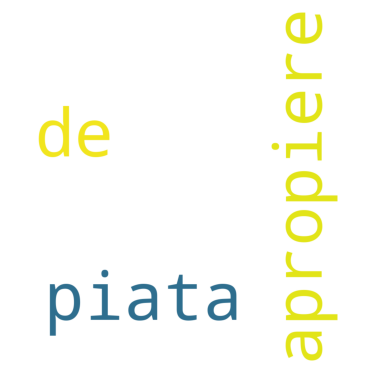

In [15]:
from nlp.visualization import generate_cloud

all_false_positive_words = []
for phrases in df2["false_positive_words_string"]:
    if len(phrases) < 1:
        pass
    else:
        all_false_positive_words.append(phrases)
    
generate_cloud(df2["false_positive_words_string"])

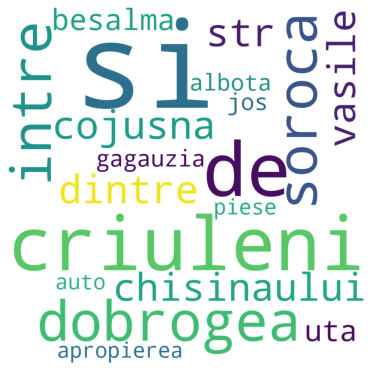

In [16]:
all_false_positive_words = []
for phrases in df2["false_negative_words_string"]:
    if len(phrases) < 1:
        pass
    else:
        all_false_positive_words.append(phrases)
    
generate_cloud(df2["false_negative_words_string"])

## Analysis of the model metrics
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png "Title")

UAS (Unlabelled Attachment Score) and LAS (Labelled Attachment Score) are standard metrics to evaluate dependency parsing. UAS is the proportion of tokens whose head has been correctly assigned, LAS is the proportion of tokens whose head has been correctly assigned with the right dependency label (subject, object, etc).

ents_p = precision ||
ents_r = recall ||
ents_f = fscore ||
for the NER task
tags_acc is the POS tagging accuracy.
token_acc is precision for token segmentation.

In [17]:
# • recall
# • presicion
# • confusion matrix
# • example paterns in false positives
# • example paterns in false negatives

from nlp.evaluate import evaluate



all_examples = testing_data
real_examples = testing_data_real
generated_examples = testing_data_generated

results = evaluate(nlp, all_examples)
print(f"--------------------------\nFor all_examples\nprecision is: {results['ents_p']}\nrecall is: {results['ents_r']}\nfscore is: {results['ents_f']}")

results = evaluate(nlp, real_examples)
print(f"-------------------------\nFor real_examples\nprecision is: {results['ents_p']}\nrecall is: {results['ents_r']}\nfscore is: {results['ents_f']}")

results = evaluate(nlp, generated_examples)
print(f"-------------------------\nFor generated_examples\nprecision is: {results['ents_p']}\nrecall is: {results['ents_r']}\nfscore is: {results['ents_f']}")

--------------------------
For all_examples
precision is: 95.91836734693877
recall is: 98.74568830354343
fscore is: 97.31149567367119
-------------------------
For real_examples
precision is: 72.28144989339019
recall is: 95.49295774647887
fscore is: 82.28155339805825
-------------------------
For generated_examples
precision is: 99.85785358919688
recall is: 99.15314043754411
fscore is: 99.5042492917847
